# Final Code and Explanation Evaluation

It will compute pedagogical quality metrics for the explanation texts—such as readability and coherence—and evaluate how well each explanation relates to its corresponding code snippet.


In [1]:
!pip install -q pandas textstat sentence-transformers spacy textdescriptives matplotlib seaborn scikit-learn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [1]:
import pandas as pd
import numpy as np
import textstat
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import textdescriptives as td
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Load Our Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/MyDrive/test/data'

# Define a universal read function to handle potential numpy._core import issues
def load_pickle(path):
    try:
        df = pd.read_pickle(path)
        return df
    except Exception as e:
        print(f"Standard loading failed for {path}: {e}")
        import numpy as np
        import sys, types
        numpy_core_mod = types.ModuleType("numpy._core")
        for attr in dir(np.core):
            try:
                setattr(numpy_core_mod, attr, getattr(np.core, attr))
            except Exception:
                pass
        sys.modules["numpy._core"] = numpy_core_mod
        df = pd.read_pickle(path)
        return df

# Load the three datasets

easy_df = load_pickle(f"{drive_path}/Easy_version1_results.pkl")
medium_df = load_pickle(f"{drive_path}/Medium_version1_results.pkl")
hard_df = load_pickle(f"{drive_path}/Hard_version1_results.pkl")

# Add a difficulty column to each dataset for later identification
easy_df['difficulty'] = 'Easy'
medium_df['difficulty'] = 'Medium'
hard_df['difficulty'] = 'Hard'

# Concatenate the three datasets into one
df_all = pd.concat([easy_df, medium_df, hard_df], ignore_index=True)

# Display basic information to ensure the expected columns exist
print(df_all[['difficulty','final_code','final_explain']].head(12))

Standard loading failed for /content/drive/MyDrive/test/data/Easy_version1_results.pkl: No module named 'numpy._core.numeric'
   difficulty                                         final_code  \
0        Easy  class Solution:\n    def maximumNumberOfString...   
1        Easy  ```python\nclass Solution:\n    def distanceTr...   
2        Easy  class Solution:\ndef longestAlternatingSubarra...   
3        Easy  class Solution:\n    def alternatingSubarray(s...   
4      Medium  class Solution:\n    def countServers(self, n:...   
5      Medium  class Solution:\n    def relocateMarbles(self,...   
6      Medium  ```python\nclass Solution:\n    def matrixSumQ...   
7      Medium  class Solution:\n    def findValueOfPartition(...   
8        Hard  class Solution:\n    def sumImbalanceNumbers(s...   
9        Hard  class Solution:\n    def minimumChanges(self, ...   
10       Hard  class Solution:\n    def longestValidSubstring...   
11       Hard  class Solution:\n    def findMaximumEleganc

/tmp/ipython-input-3786453643.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([easy_df, medium_df, hard_df], ignore_index=True)


## Readability Metrics

In [5]:
# Define a function to compute readability metrics using textstat

def compute_readability(text: str) -> dict:
    # If the text is empty, return NaN values
    if not isinstance(text, str) or not text.strip():
        return {
            'flesch_reading_ease': np.nan,
            'flesch_kincaid_grade': np.nan,
            'smog_index': np.nan,
            'gunning_fog': np.nan,
        }
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text),
        'gunning_fog': textstat.gunning_fog(text),
    }

# Apply the readability function to each explanation
df_readability = df_all['final_explain'].apply(compute_readability).apply(pd.Series)

# Merge the readability scores back into the main DataFrame
df_all = pd.concat([df_all, df_readability], axis=1)

# Print the first few rows to check the computed metrics
print(df_all[['difficulty', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog_index', 'gunning_fog']].head(12))

   difficulty  flesch_reading_ease  flesch_kincaid_grade  smog_index  \
0        Easy            53.120000              9.825000   12.161745   
1        Easy            58.535000             11.483016   10.608841   
2        Easy            76.559635              4.935892    8.364918   
3        Easy            75.201294              6.800603   10.535541   
4      Medium            53.473226             13.502151   11.208143   
5      Medium            42.714333             11.442000   15.021130   
6      Medium            50.222319             15.777391   14.068176   
7      Medium            34.586466             12.037414   13.023867   
8        Hard            58.787500              8.165000   10.686353   
9        Hard            72.106739              8.460276   11.538035   
10       Hard            58.171429              8.623571   11.208143   
11       Hard            53.361168              9.605041   12.384807   

    gunning_fog  
0     11.400000  
1     12.952381  
2      6.

## Coherence Metrics

In [6]:
# Use spaCy and textdescriptives to compute coherence metrics
nlp = spacy.load('en_core_web_sm')

# Add the coherence component from textdescriptives to the pipeline
nlp.add_pipe('textdescriptives/coherence', last=True)

# Define a function to compute coherence metrics

def compute_coherence(texts):
    first_order_scores = []
    second_order_scores = []
    for doc in nlp.pipe(texts):
        # Get the coherence result dictionary for the document
        coherence_dict = doc._.coherence
        first_order_scores.append(coherence_dict.get('first_order_coherence'))
        second_order_scores.append(coherence_dict.get('second_order_coherence'))
    return first_order_scores, second_order_scores

# Compute coherence for all explanation texts
first_order, second_order = compute_coherence(df_all['final_explain'].astype(str).tolist())

# Add the results to the DataFrame
df_all['first_order_coherence'] = first_order
df_all['second_order_coherence'] = second_order

# Display the coherence metrics
print(df_all[['difficulty', 'first_order_coherence', 'second_order_coherence']].head(12))

   difficulty  first_order_coherence  second_order_coherence
0        Easy               0.456138                     NaN
1        Easy               0.482977                0.393584
2        Easy               0.552852                0.451019
3        Easy               0.969859                0.964232
4      Medium               0.243008                0.118837
5      Medium               0.159438                0.295345
6      Medium               0.176243                0.284669
7      Medium               0.353627                     NaN
8        Hard               0.408064                0.246625
9        Hard               0.460456                0.238582
10       Hard               0.534421                0.479999
11       Hard               0.362240                0.465697


/usr/local/lib/python3.11/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))


## Cosine Similarity Between Code and Explanation

In [9]:
# Use the CodeBERT model to compute embeddings for code and explanation texts, then calculate cosine similarity

# Choose the model name (you can replace it with another model that supports both code and natural language)
model_name = 'microsoft/codebert-base'

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define a function to obtain sentence embeddings using mean pooling

def get_embedding(text: str) -> np.ndarray:
    # If the text is empty or not a string, return a zero vector
    if not isinstance(text, str) or not text.strip():
        return np.zeros(model.config.hidden_size)
    encoded_input = tokenizer(text, truncation=True, max_length=512, padding='max_length', return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    token_embeddings = model_output.last_hidden_state  # (batch_size, seq_len, hidden_size)
    attention_mask = encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
    sum_mask = attention_mask.sum(dim=1)
    embeddings = sum_embeddings / torch.clamp(sum_mask, min=1e-9)
    return embeddings.cpu().numpy()[0]

# Compute embeddings for each row's code and explanation
code_embeddings = []
explain_embeddings = []
for code_text, explain_text in zip(df_all['final_code'].astype(str), df_all['final_explain'].astype(str)):
    code_embeddings.append(get_embedding(code_text))
    explain_embeddings.append(get_embedding(explain_text))

# Calculate cosine similarity between each pair of embeddings
similarities = [cosine_similarity([c_emb], [e_emb])[0][0] for c_emb, e_emb in zip(code_embeddings, explain_embeddings)]

# Add similarity scores to the DataFrame
df_all['code_explain_similarity'] = similarities

# Display similarity results
print(df_all[['difficulty', 'code_explain_similarity']].head(12))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


   difficulty  code_explain_similarity
0        Easy                 0.937465
1        Easy                 0.875391
2        Easy                 0.933488
3        Easy                 0.871511
4      Medium                 0.921867
5      Medium                 0.933260
6      Medium                 0.878432
7      Medium                 0.943791
8        Hard                 0.936981
9        Hard                 0.898863
10       Hard                 0.891078
11       Hard                 0.896171


## Visulization

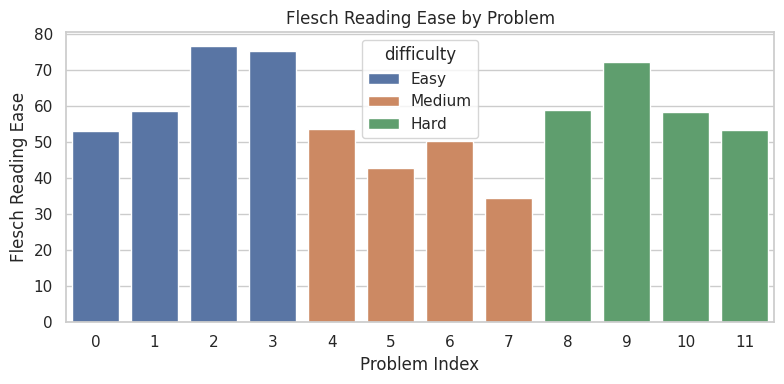

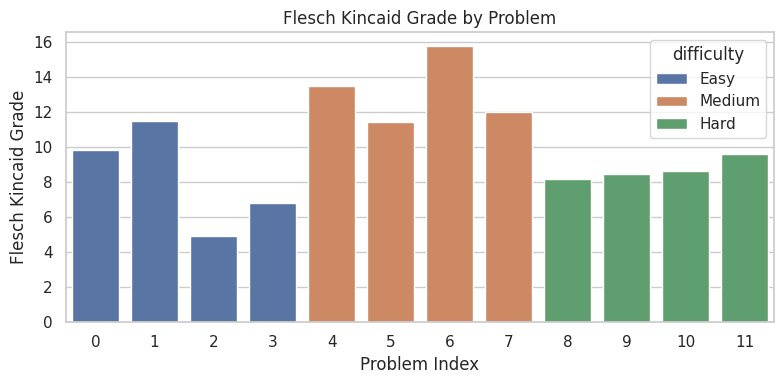

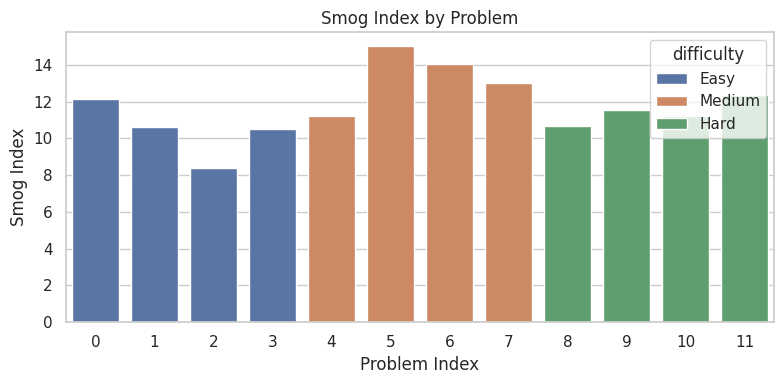

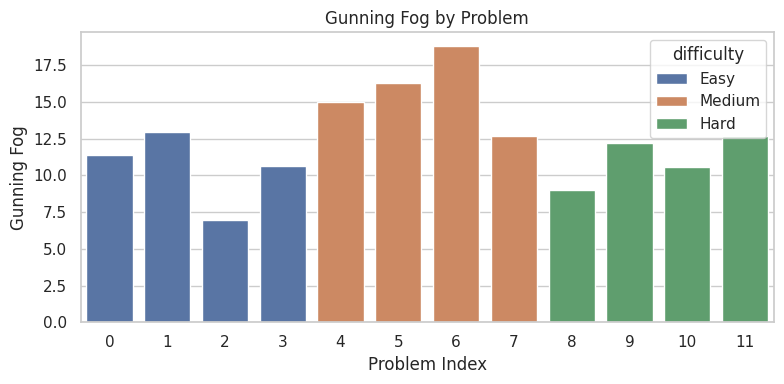

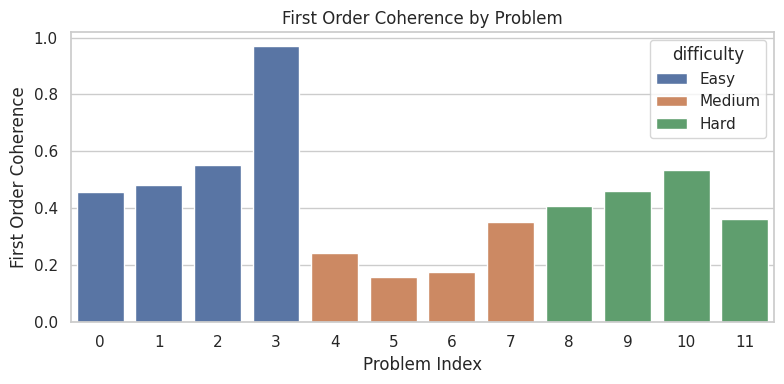

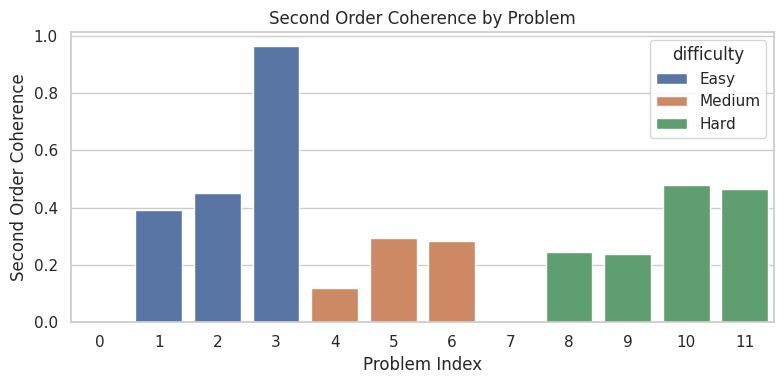

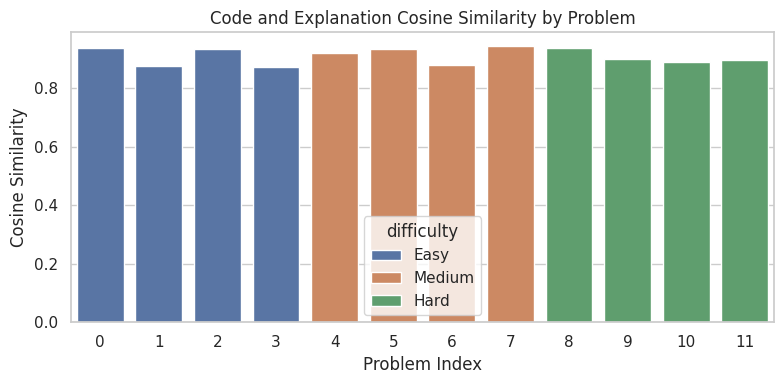

In [11]:
# Visualize the distribution of different metrics

# Set the font to display Chinese characters if present
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot readability metrics
readability_metrics = ['flesch_reading_ease', 'flesch_kincaid_grade', 'smog_index', 'gunning_fog']
for metric in readability_metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df_all.index, y=metric, hue=df_all['difficulty'], dodge=False, data=df_all)
    plt.title(f'{metric.replace("_", " ").title()} by Problem')
    plt.xlabel('Problem Index')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot coherence metrics
coherence_metrics = ['first_order_coherence', 'second_order_coherence']
for metric in coherence_metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df_all.index, y=metric, hue=df_all['difficulty'], dodge=False, data=df_all)
    plt.title(f'{metric.replace("_", " ").title()} by Problem')
    plt.xlabel('Problem Index')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot similarity between code and explanation
plt.figure(figsize=(8, 4))
sns.barplot(x=df_all.index, y='code_explain_similarity', hue=df_all['difficulty'], dodge=False, data=df_all)
plt.title('Code and Explanation Cosine Similarity by Problem')
plt.xlabel('Problem Index')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
mean_by_difficulty = df_all.groupby('difficulty').mean(numeric_only=True)

#metric_cols = ['code_explain_similarity', 'your_other_metric1', 'your_other_metric2']
#mean_by_difficulty = df_all.groupby('difficulty')[metric_cols].mean()

print(mean_by_difficulty)

            first_assert_iter  passed  pass_iteration  flesch_reading_ease  \
difficulty                                                                   
Easy                      NaN    0.25             1.0            65.853982   
Hard                      1.0    0.25             4.0            60.606709   
Medium                    1.0    0.25             1.0            45.249086   

            flesch_kincaid_grade  smog_index  gunning_fog  \
difficulty                                                  
Easy                    8.261128   10.417761    10.496189   
Hard                    8.713472   11.454334    11.125893   
Medium                 13.189739   13.330329    15.688864   

            first_order_coherence  second_order_coherence  \
difficulty                                                  
Easy                     0.615456                0.602945   
Hard                     0.441295                0.357726   
Medium                   0.233079                0.232950  

In [13]:
drive_output_path = '/content/drive/MyDrive/evaluation_results.csv'
df_all.to_csv(drive_output_path, index=False)
print(f'Results saved to {drive_output_path}')

Results saved to /content/drive/MyDrive/evaluation_results.csv
